In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
#from pulearn import WeightedElkanotoPuClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import warnings

# Ignore the "DeprecationWarning" warning
warnings.filterwarnings('ignore', category=DeprecationWarning)


In [2]:
local_stringdb = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/data/string/lfs-stringdb/'
# load local STRING database and names
stringdf = pd.read_csv(local_stringdb+'9606.protein.info.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
stringdf['preferred_name'] = stringdf['preferred_name'].str.upper()
stringId2name = stringdf.set_index('#string_protein_id')['preferred_name'].to_dict()
name2stringId = stringdf.set_index('preferred_name')['#string_protein_id'].to_dict()
stringdf = pd.read_csv(local_stringdb+'9606.protein.aliases.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'alias']).drop_duplicates(['alias'], keep='first')
stringdf['alias'] = stringdf['alias'].str.upper()
aliases2stringId = stringdf.set_index('alias')['#string_protein_id'].to_dict()

def get_df(dataset,dim):

    files_path = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/results/models/Dataset-'+dataset+'--RE-True--W-True--Epochs-15000--D-'+dim+'--RH-25--LR-0.1--LP-False--CUDA-True/'
    path1 = files_path + 'latent.pkl'
    path2 = files_path + 'RE.pkl'

    with open(path1, 'rb') as file:
        latent = pickle.load(file)
    latent = np.array(latent)
    with open(path2, 'rb') as file:
        re = pickle.load(file)
    re = np.array(re)

    convertpath = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/data/datasets/'+dataset+'/ppi_index.pkl'
    with open(convertpath, 'rb') as file:
        ppi_index = pickle.load(file)
    data = np.concatenate((latent, re[:, np.newaxis]), axis=1)
    df_latent = pd.DataFrame()
    for i, d in enumerate(range(data.shape[1])):
        if i == len(range(data.shape[1]))-1:
            col_name = 're'
        else:
            col_name = str(d+1)+'d'
        df_latent[col_name] = data.T[d]
    df_latent['node'] = df_latent.index
    inv_dict = {v: k for k, v in ppi_index.items()}
    df_latent = df_latent.add_prefix(dataset+'_')
    df_latent['gene'] = df_latent[dataset+'_node'].map(inv_dict)
    df = df_latent.loc[:, ~df_latent.columns.str.endswith('node')]
    return df
def test_methods(X,y,rm_id):
    f1s = []
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rm_id)

    # Fit the WeightedElkanotoPuClassifier with SVC estimator on the training set
    svc = SVC(C=10, kernel='rbf', gamma=0.4, probability=True)
    pu_estimator = WeightedElkanotoPuClassifier(estimator=svc, labeled=10, unlabeled=20)
    pu_estimator.fit(X_train, y_train)

    # Predict the labels of the test set
    y_pred = pu_estimator.predict(X_test)
    # Calculate the f1-score of the positive class
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
    # print("SVC_PU F1-score of positive class: ", f1_score[1])
    f1s.append(f1_score[1])

    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    # Calculate the f1-score of the positive class
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
    # print("SVC F1-score of positive class: ", f1_score[1])
    f1s.append(f1_score[1])

    rf = RandomForestClassifier(
                n_estimators=100,
                criterion='gini',
                bootstrap=True,
                n_jobs=1,
            )

    # Create the weighted Elkanoto-PU classifier
    pu_estimator = WeightedElkanotoPuClassifier(estimator=rf, labeled=10, unlabeled=20)
    pu_estimator.fit(X_train, y_train)
    y_pred = pu_estimator.predict(X_test)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
    # print("RF_PU F1-score of positive class: ", f1_score[1])
    f1s.append(f1_score[1])

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # Calculate the f1-score of the positive class
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
    # print("RF F1-score of positive class: ", f1_score[1])
    f1s.append(f1_score[1])
    return f1s


In [41]:
ppidf = get_df('ppi','4')
scdf = get_df('sc_endo','4')
stdf = get_df('st','4')
df = pd.merge(ppidf,scdf,on='gene')
df = pd.merge(df,stdf,on='gene')
print(len(ppidf),len(scdf),len(stdf),len(df))
root = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/data/disease/'
disease_source = 'DIS_CAD'
diseasedf = pd.read_csv(root+disease_source+'.tsv',sep='\t')
pos_genes = diseasedf['Gene']
pos_genes = pos_genes.map(aliases2stringId)
pos_genes =  pos_genes.map(stringId2name)
print(len(diseasedf),len(set(pos_genes)))
df['label'] = df['gene'].apply(lambda x: 1 if x in pos_genes.to_list() else -1)

y = df['label'].to_numpy()
filtered_df = df.filter(regex='^(ppi|sc|st)')
X = filtered_df
print(len(np.where(y == 1.)[0]),len(np.where(y == -1.)[0]))

18767 5170 17121 4272
1708 1520


In [42]:
len(df)

4272

In [43]:
df.to_csv('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/data/ppi_scendo_st_4.csv',index = False)

285 1288


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
print(precision[1],recall[1],f1_score[1])
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

0.8333333333333334 0.18518518518518517 0.303030303030303


ppi_re         0.101496
ppi_2d         0.093397
ppi_3d         0.079233
ppi_1d         0.076022
ppi_4d         0.071817
sc_macro_2d    0.069234
sc_macro_re    0.062204
sc_macro_3d    0.061117
sc_macro_4d    0.059931
st_4d          0.057160
sc_macro_1d    0.056192
st_re          0.055739
st_3d          0.054823
st_2d          0.053766
st_1d          0.047869
dtype: float64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
print(precision[1],recall[1],f1_score[1])
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

0.8333333333333334 0.18518518518518517 0.303030303030303


ppi_re         0.101496
ppi_2d         0.093397
ppi_3d         0.079233
ppi_1d         0.076022
ppi_4d         0.071817
sc_macro_2d    0.069234
sc_macro_re    0.062204
sc_macro_3d    0.061117
sc_macro_4d    0.059931
st_4d          0.057160
sc_macro_1d    0.056192
st_re          0.055739
st_3d          0.054823
st_2d          0.053766
st_1d          0.047869
dtype: float64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
print(precision[1],recall[1],f1_score[1])
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

0.5 0.09734513274336283 0.16296296296296295


ppi_re         0.109947
ppi_2d         0.088056
ppi_1d         0.085544
ppi_4d         0.076431
ppi_3d         0.068517
st_re          0.065099
sc_tcell_re    0.060222
sc_tcell_2d    0.059586
sc_tcell_3d    0.058189
sc_tcell_1d    0.056969
st_1d          0.056411
sc_tcell_4d    0.054532
st_2d          0.054178
st_4d          0.053850
st_3d          0.052468
dtype: float64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
print(precision[1],recall[1],f1_score[1])
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

0.5263157894736842 0.03484320557491289 0.065359477124183


ppi_re    0.091447
ppi_2d    0.090160
ppi_1d    0.082401
ppi_4d    0.079889
ppi_3d    0.074951
st_re     0.063929
sc_re     0.061960
st_3d     0.058418
sc_2d     0.057910
st_4d     0.057416
st_1d     0.057235
sc_3d     0.056580
st_2d     0.056443
sc_1d     0.055816
sc_4d     0.055444
dtype: float64

In [14]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
print(precision[1],recall[1],f1_score[1])
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

0.6428571428571429 0.075 0.13432835820895522


ppi_re        0.095782
ppi_1d        0.080278
ppi_4d        0.079870
ppi_2d        0.077167
ppi_3d        0.068875
sc_vsmc_re    0.066970
sc_vsmc_4d    0.064216
sc_vsmc_2d    0.063613
st_re         0.061594
sc_vsmc_3d    0.060349
sc_vsmc_1d    0.058429
st_2d         0.057014
st_4d         0.056132
st_1d         0.055849
st_3d         0.053862
dtype: float64

In [78]:
ppidf = get_df('ppi','8')

df = pd.merge(ppidf,scdf,on='gene')
df = pd.merge(df,stdf,on='gene')
print(len(ppidf),len(scdf),len(stdf),len(df))
root = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/HBDM/data/disease/'
disease_source = 'DIS_CAD'
diseasedf = pd.read_csv(root+disease_source+'.tsv',sep='\t')
pos_genes = diseasedf['Gene']
pos_genes = pos_genes.map(aliases2stringId)
pos_genes =  pos_genes.map(stringId2name)
print(len(diseasedf),len(set(pos_genes)))
df['label'] = df['gene'].apply(lambda x: 1 if x in pos_genes.to_list() else -1)

18767 16773 17121 15298
1708 1520


In [84]:
X = df[['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d', 'ppi_5d', 'ppi_6d', 'ppi_7d',
       'ppi_8d', 'ppi_re','sc_1d',
        'sc_2d', 'sc_3d', 'sc_4d', 'sc_re', 'st_1d', 'st_2d', 'st_3d', 'st_4d',
        'st_re']]
y = df['label'].to_numpy()
print(len(np.where(y == 1.)[0]),len(np.where(y == -1.)[0]))

1361 13937


In [85]:
results = []
for rmid in [14,42,78,65,49]:
    temp = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rmid)
    print(len(np.where(y_train == 1.)[0]),len(np.where(y_train == -1.)[0]))
    print(len(np.where(y_test == 1.)[0]),len(np.where(y_test == -1.)[0]))
    temp.append(sub_feature(['sc_1d', 'sc_2d','sc_3d', 'sc_4d', 'sc_re'],X_train,X_test,y_train,y_test))
    temp.append(sub_feature(['st_1d', 'st_2d', 'st_3d', 'st_4d', 'st_re'],X_train,X_test,y_train,y_test))
    temp.append(sub_feature(['ppi_1d', 'ppi_2d', 'ppi_3d', 'ppi_4d', 'ppi_5d', 'ppi_6d', 'ppi_7d',
       'ppi_8d', 'ppi_re'],X_train,X_test,y_train,y_test))
    temp.append(sub_feature(X.columns,X_train,X_test,y_train,y_test))
    results.append(temp)

1088 11150
273 2787
1074 11164
287 2773
1120 11118
241 2819
1082 11156
279 2781
1080 11158
281 2779


In [86]:
results

[[0.0, 0.0, 0.15757575757575756, 0.06779661016949154],
 [0.0, 0.006872852233676975, 0.14792899408284024, 0.06557377049180327],
 [0.0, 0.0, 0.19863013698630136, 0.10526315789473685],
 [0.0, 0.0, 0.1451104100946372, 0.08163265306122451],
 [0.0, 0.0, 0.14197530864197533, 0.07868852459016394]]

In [88]:

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
print(precision[1],recall[1],f1_score[1])
# view the feature scores

feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

0.5 0.042704626334519574 0.07868852459016394


ppi_re    0.074893
ppi_8d    0.061713
ppi_4d    0.060493
ppi_1d    0.060464
ppi_7d    0.058555
ppi_6d    0.058040
ppi_3d    0.057592
ppi_5d    0.056548
ppi_2d    0.055003
st_re     0.051139
sc_re     0.047533
st_1d     0.046048
sc_1d     0.046041
st_3d     0.045715
st_4d     0.045335
sc_3d     0.044704
sc_4d     0.044314
st_2d     0.043048
sc_2d     0.042821
dtype: float64

In [75]:
X_train2 = X_train[feature_scores.index.tolist()[:7]]
X_test2 = X_test[feature_scores.index.tolist()[:7]]
clf.fit(X_train2, y_train)
y_pred = clf.predict(X_test2)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, labels=[-1, 1])
print(precision[1],recall[1],f1_score[1])

0.6333333333333333 0.06761565836298933 0.12218649517684889


In [45]:
import matplotlib.pyplot as plt
pos = df[df['label']==1.].index.to_list()


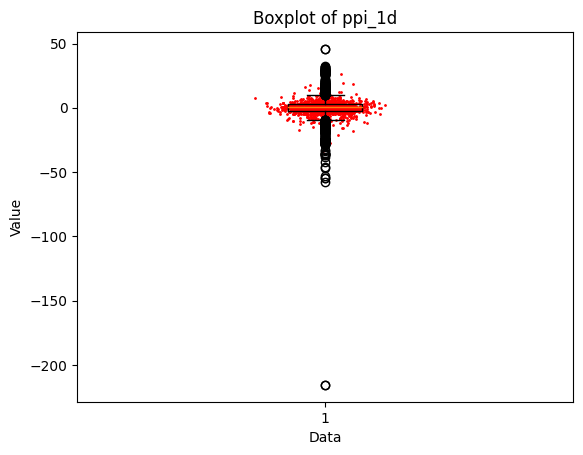

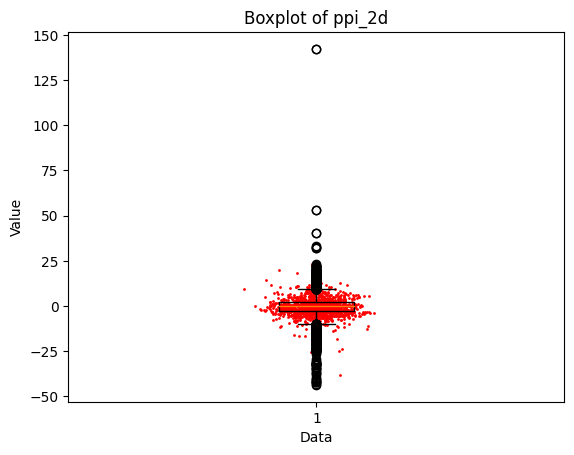

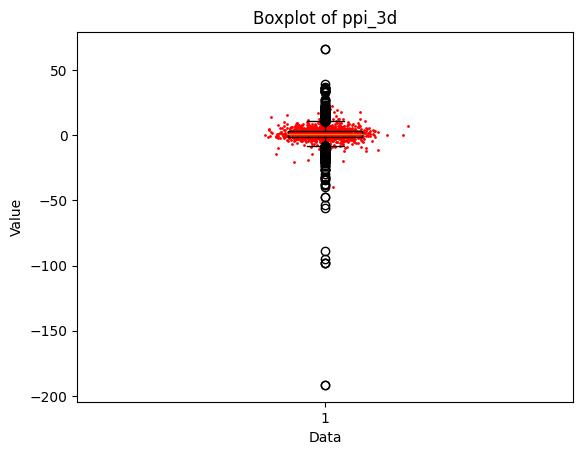

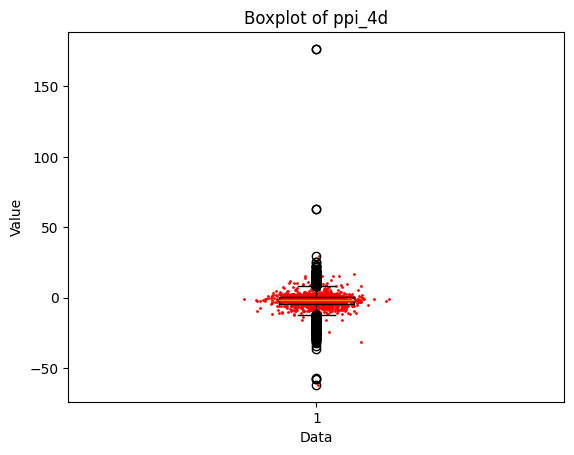

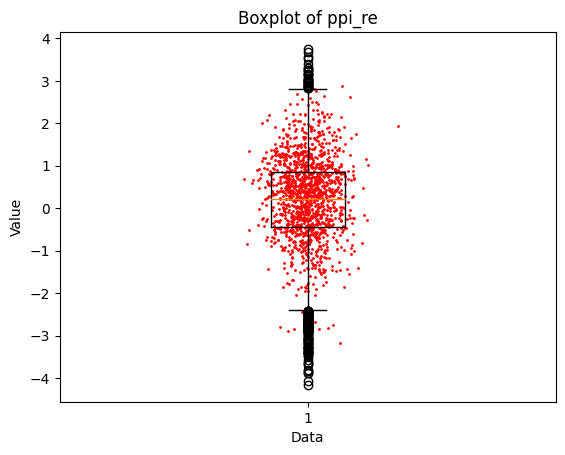

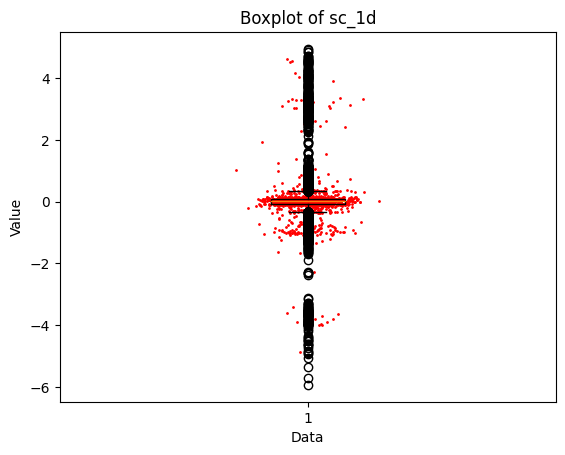

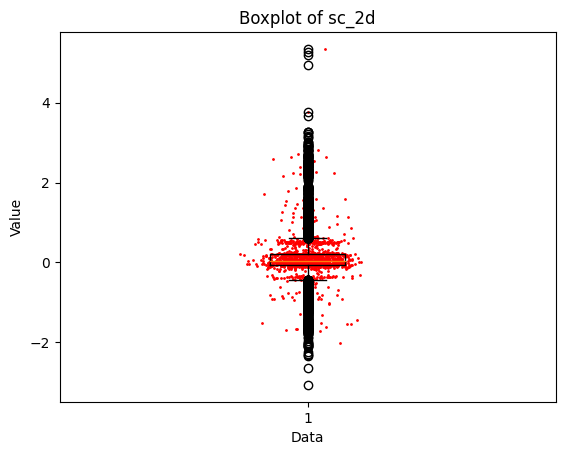

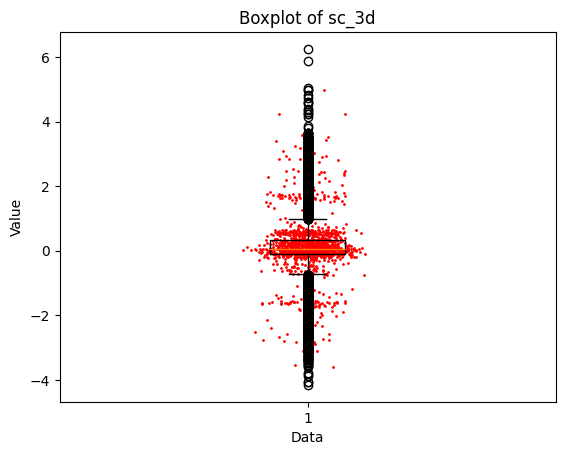

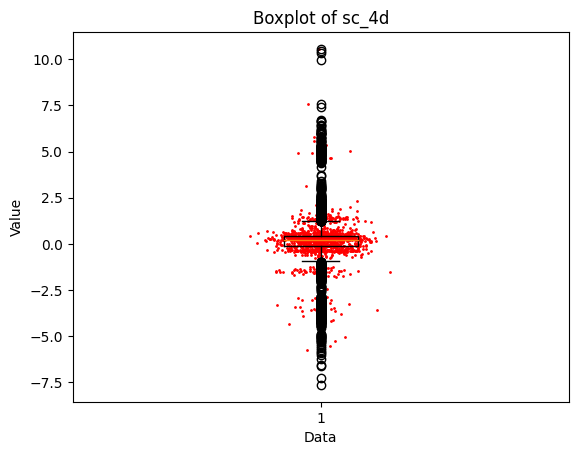

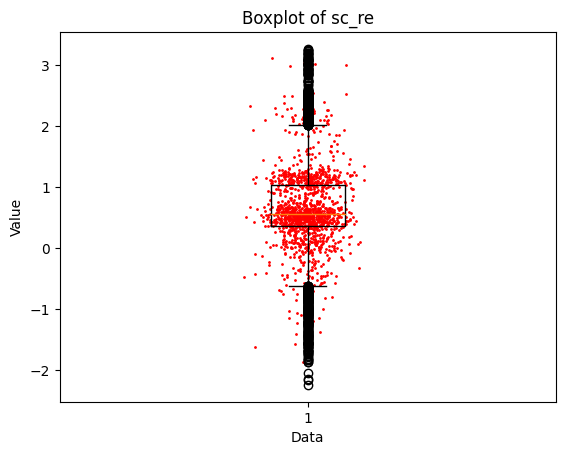

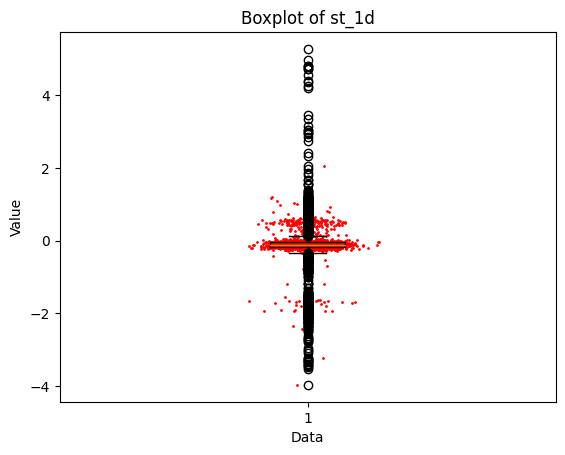

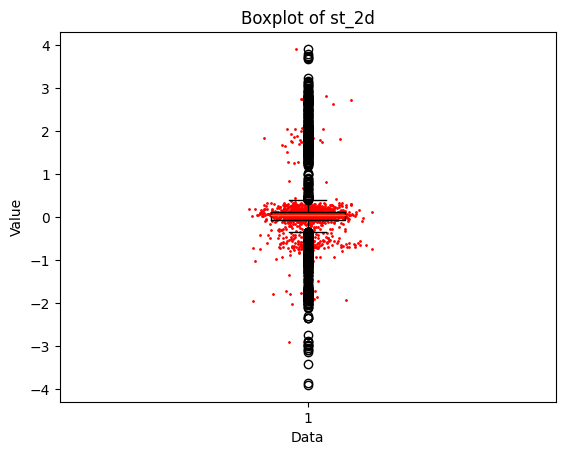

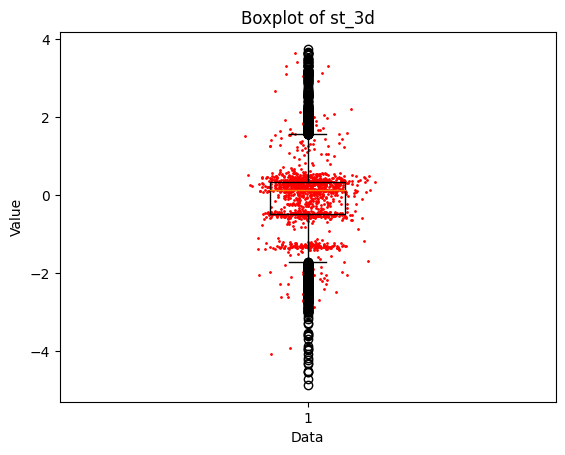

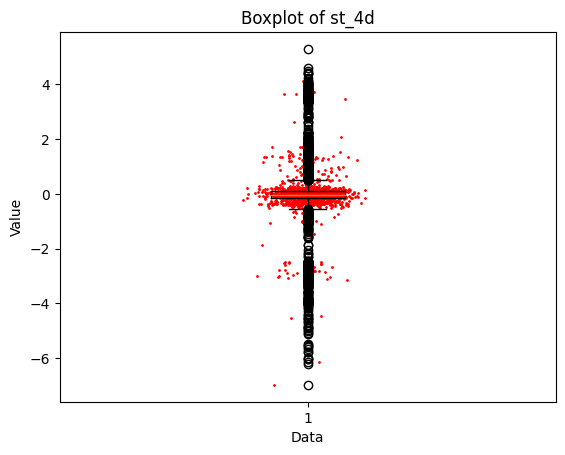

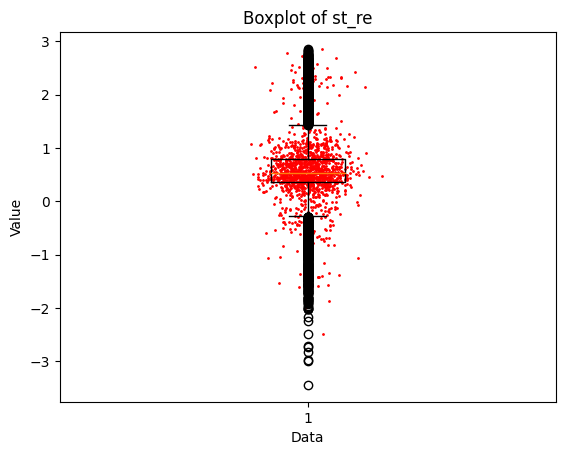

In [58]:
import matplotlib.pyplot as plt

for col in X.columns:
    # list of numbers
    data = X[col]

    # list of positions to highlight
    b = pos

    # create jittered x-coordinates
    xs = np.random.normal(1, 0.04, len(data))

    # create a boxplot
    plt.boxplot(data)

    # highlight the specific positions
    for i in b:
        plt.scatter(xs[i-1], data[i-1], color='red',s=1)

    # set title and labels
    plt.title('Boxplot of '+col)
    plt.xlabel('Data')
    plt.ylabel('Value')

    # show the plot
    plt.show()